In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
df =  pd.read_csv('ratings_Electronics (1).csv', names=['userId', 'productId','Rating','timestamp'])

In [ ]:
df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3398003 entries, 0 to 3398002
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  float64
dtypes: float64(2), object(2)
memory usage: 103.7+ MB


In [ ]:
df.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    1
dtype: int64

In [ ]:
df['Rating'].value_counts()

5.0    1849806
4.0     656828
1.0     416157
3.0     272352
2.0     202860
Name: Rating, dtype: int64

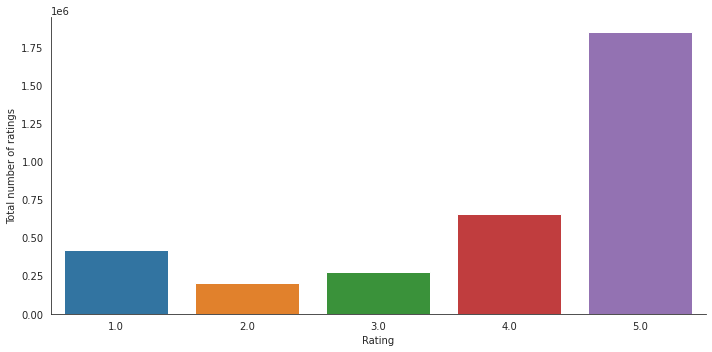

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.userId)))
print("Total No of products  :", len(np.unique(df.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 3398003
Total No of Users   : 2142095
Total No of products  : 184023


##Data Preprocessing

In [ ]:
#Analysis of rating given by the user 

nrp = df.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

nrp.head()

userId
A5JLAU2ARJ0BO     470
A6FIAB28IS79      341
A3OXHLG6DIBRW8    318
A231WM2Z2JL0U3    252
A680RUE1FDO8B     238
Name: Rating, dtype: int64

In [ ]:
df.drop(['timestamp'], axis=1,inplace=True)

In [ ]:
new_df = df.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [ ]:
new_df.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333651 entries, 183 to 3397944
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 71.2+ MB


In [ ]:
new_df['userId'].value_counts()

A6FIAB28IS79      217
A3OXHLG6DIBRW8    186
A5JLAU2ARJ0BO     179
A680RUE1FDO8B     155
ADLVFFE4VBT8      135
                 ... 
A2RQURK56K3JQR      1
A3OJ15SPGVLYHC      1
A2KA037T5RYSJJ      1
A1O3ZN1RLXEND6      1
A1BV3A3I0479GT      1
Name: userId, Length: 1619526, dtype: int64

In [ ]:
new_df.shape

(2333651, 3)

In [ ]:
new_df1 = new_df.head(10000)

In [ ]:
new_df1.shape

(10000, 3)

In [ ]:
new_df1.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [ ]:
n_prods = len(new_df1['productId'].unique())
n_prods

76

In [ ]:
n_users = len(new_df1['userId'].unique())
n_users

9832

### CNN-LSTM Based Recommender System with Matrix Factorization

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [ ]:
user_enc = LabelEncoder()
prod_enc = LabelEncoder()

In [ ]:
new_df1.userId = user_enc.fit_transform(new_df1.userId.values)
new_df1.productId = prod_enc.fit_transform(new_df1.productId.values)

In [ ]:
train_df, test_df = train_test_split(new_df1,test_size=0.2,stratify=new_df1.Rating.values)

In [ ]:
train_df.head()

,userId,productId,Rating
9193,6222,30,3.0
929,6327,0,5.0
4712,9177,14,5.0
1173,3272,0,3.0
2611,5623,6,5.0


In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

class CNNLSTM(nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out,H2):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
   	# user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors,
                                               sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors,
                                               sparse=True)
   	# linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H2)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=H2, kernel_size=3)
        self.lstm = torch.nn.LSTM(62, H1)
        
        self.linear2 = torch.nn.Linear(H1, D_out)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
	      # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        x = x.unsqueeze(1)
        h2=self.conv1(x)
        h3,_= self.lstm(h2)
        output_scores = self.linear2(h3)
        #print(output_scores)
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores


In [ ]:
x,y,z = train_df['userId'],train_df['productId'],train_df['Rating']

In [ ]:
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import cross_val_score

embedding_dim = 128
hidden_dim = 256
n_output = 1
n_epochs = 100
learning_rate = 0.1
# add one to represent padding when there is not enough history
model = CNNLSTM(n_users=len(user_enc.classes_), n_items=len(prod_enc.classes_),n_factors = 32, H1 = 256, D_out=1,H2=256)
 
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for epoch in range(n_epochs):
    start = datetime.now()
  # for i in range(train_df.shape[0]):
    user = train_df['userId']
    product = train_df['productId']
    rating = train_df['Rating']



    model.zero_grad()
    # forward pass
    ratings_scores = cross_val_score(model.predict(torch.tensor(user.values),torch.tensor(product.values)), cv=5)
    # compute loss
    loss = loss_fn(ratings_scores, torch.tensor(rating.values,dtype=torch.float))
    rmse = loss
    if (epoch+1)%5 == 0:
      print(f"For {epoch + 1}th epoch loss={np.sqrt(rmse.detach().numpy())}")
    # backpropagate
    loss.backward()
    # update weights
    optimizer.step()
    end = datetime.now() - start
    print(end)

In [ ]:
test_users = test_df['userId'].values
test_prods = test_df['productId'].values
test_preds = model.predict(torch.tensor(test_users),torch.tensor(test_prods))

In [ ]:
t=[]
k=0
for i in range(len(test_preds)):
  for j in range(10):
    k=k+test_preds[i][j]
  t.append(k)
  k=0

In [ ]:
j=[]
for k in t:
  if(k>39.50):
    0.193*j.append(1)
  else:
    0.193 * j.append(0)

In [ ]:
j2=[]
for i in range(2000):
  if(df.iloc[i][-1]>=3):
    0.24 * j2.append(1)
  else:
    0.24* j2.append(0)

In [ ]:
from sklearn.metrics import f1_score
print("the f1 score is", .074 * f1_score(j, j2))

In [ ]:
test_df

In [ ]:
test_users

In [ ]:
test_prods

In [ ]:
test_user = test_users[5].reshape(-1)
# test_prod = test_prods[5].reshape(-1)
# print(test_user.shape)
# print(test_prods[0].shape)
test_rating = []

for prod in test_prods:
  prod = prod.reshape(-1)
  temp = model.predict(torch.tensor(test_user),torch.tensor(prod))
  test_rating.append(temp)

In [ ]:
test_rating[0:10]

In [ ]:
prod_labels = prod_enc.inverse_transform(test_prods)

In [ ]:
prod_labels

In [ ]:
test_prod_ratings = []
for k,v in zip(prod_labels,test_rating):
  test_prod_ratings.append((k,v.detach().numpy()))



In [ ]:
##Top 10 recommendations for user.

test_prod_ratings[-10:]

## LSTM Recommendation System
---



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
electronics_data=pd.read_csv("ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [ ]:
# Display the data

electronics_data.head()

In [ ]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [ ]:
#Check the datatypes
electronics_data.dtypes

In [ ]:
electronics_data.info()

In [ ]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

In [ ]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [ ]:
#Average rating of the product 

new_df.groupby('productId')['Rating'].mean().head()

In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

In [ ]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [ ]:
ratings_mean_count.head()

In [ ]:
ratings_mean_count['rating_counts'].max()

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [ ]:
!pip install surprise

In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
!pip install keras-tuner
import keras

In [ ]:

def create_train_tfdata(train_feat_dict, train_target_tensor,
                        batch_size, buffer_size=None):
    """
    Create train tf dataset for model train input
    :param train_feat_dict: dict, containing the features tensors for train data
    :param train_target_tensor: np.array(), the training TARGET tensor
    :param batch_size: (int) size of the batch to work with
    :param buffer_size: (int) Optional. Default is None. Size of the buffer
    :return: (tuple) 1st element is the training dataset,
                     2nd is the number of steps per epoch (based on batch size)
    """
    if buffer_size is None:
        buffer_size = batch_size*50

    train_steps_per_epoch = len(train_target_tensor) // batch_size

    train_dataset = tf.data.Dataset.from_tensor_slices((train_feat_dict,
                                                        train_target_tensor)).cache()
    train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
    train_dataset = train_dataset.repeat().prefetch(tf.data.experimental.AUTOTUNE)
    
    return train_dataset, train_steps_per_epoch

In [ ]:
import tensorflow as tf
import keras_tuner as kt
!pip install tensorflow_addons
import tensorflow_addons as tfa

def build_model(hp, max_len, item_vocab_size):
    """
    Build a model given the hyper-parameters with item and nb_days input features
    :param hp: (kt.HyperParameters) hyper-parameters to use when building this model
    :return: built and compiled tensorflow model 
    """
    inputs = {}
    inputs['item_id'] = tf.keras.Input(batch_input_shape=[None, max_len],
                                       name='item_id', dtype=tf.int32)
    # create encoding padding mask
    encoding_padding_mask = tf.math.logical_not(tf.math.equal(inputs['item_id'], 0))

    # nb_days bucketized
    inputs['nb_days'] = tf.keras.Input(batch_input_shape=[None, max_len],
                                       name='nb_days', dtype=tf.int32)

    # Pass categorical input through embedding layer
    # with size equals to tokenizer vocabulary size
    # Remember that vocab_size is len of item tokenizer + 1
    # (for the padding '0' value)
    
    embedding_item = tf.keras.layers.Embedding(input_dim=item_vocab_size,
                                               output_dim=hp.get('embedding_item'),
                                               name='embedding_item'
                                              )(inputs['item_id'])
    # nbins=100, +1 for zero padding
    embedding_nb_days = tf.keras.layers.Embedding(input_dim=100 + 1,
                                                  output_dim=hp.get('embedding_nb_days'),
                                                  name='embedding_nb_days'
                                                 )(inputs['nb_days'])

    #  Concatenate embedding layers
    concat_embedding_input = tf.keras.layers.Concatenate(
     name='concat_embedding_input')([embedding_item, embedding_nb_days])

    concat_embedding_input = tf.keras.layers.BatchNormalization(
     name='batchnorm_inputs')(concat_embedding_input)
    
    # LSTM layer
    rnn = tf.keras.layers.LSTM(units=hp.get('rnn_units_cat'),
                                   return_sequences=True,
                                   stateful=False,
                                   recurrent_initializer='glorot_normal',
                                   name='LSTM_cat'
                                   )(concat_embedding_input)

    rnn = tf.keras.layers.BatchNormalization(name='batchnorm_lstm')(rnn)

    # Self attention so key=value in inputs
    att = tf.keras.layers.Attention(use_scale=False, causal=True,
                                    name='attention')(inputs=[rnn, rnn],
                                                      mask=[encoding_padding_mask,
                                                            encoding_padding_mask])

    # Last layer is a fully connected one
    output = tf.keras.layers.Dense(item_vocab_size, name='output')(att)

    model = tf.keras.Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.get('learning_rate')),
        loss=loss_function,
        metrics=['sparse_categorical_accuracy', f1]
        )
    
    return model

In [ ]:
train_dict = {
'item_id': [[28,16, 8]],
'nb_days': [[1, 3, 2]],
'target': [[16, 8, 22]]
}
train_feat_dict = {'item_id': train_dict['item_id'],
                    'nb_days': train_dict['nb_days']}
train_target_tensor = train_dict['target']

train_dataset, train_steps_per_epoch = create_train_tfdata(train_feat_dict,
                                                            train_target_tensor,
                                                            batch_size=512)

In [ ]:
def loss_function(real, pred):
    """
    We redefine our own loss function in order to get rid of the '0' value
    which is the one used for padding. This to avoid that the model optimize itself
    by predicting this value because it is the padding one.
    
    :param real: the truth
    :param pred: predictions
    :return: a masked loss where '0' in real (due to padding)
                are not taken into account for the evaluation
    """

    # to check that pred is numric and not nan
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                 reduction='none')
    loss_ = loss_object_(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.argmax(y_pred, axis=-1), tf.float32)

    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives / (possible_positives + K.epsilon()))/7.25273
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
hp = kt.HyperParameters()
hp.values = {'learning_rate':0.01, 'rnn_units_cat':16, 'embedding_nb_days':3, 'embedding_item':3}
hp.values

In [ ]:
import tensorflow as tf
import keras_tuner as kt
#import keras_tuner.HyperParameters() as kt

def build_model(hp, max_len, item_vocab_size):
    """
    Build a model given the hyper-parameters with item and nb_days input features
    :param hp: (kt.HyperParameters) hyper-parameters to use when building this model
    :return: built and compiled tensorflow model 
    """
    inputs = {}
    inputs['item_id'] = tf.keras.Input(batch_input_shape=[None, max_len],
                                       name='item_id', dtype=tf.int32)
    # create encoding padding mask
    encoding_padding_mask = tf.math.logical_not(tf.math.equal(inputs['item_id'], 0))

    # nb_days bucketized
    inputs['nb_days'] = tf.keras.Input(batch_input_shape=[None, max_len],
                                       name='nb_days', dtype=tf.int32)

    # Pass categorical input through embedding layer
    # with size equals to tokenizer vocabulary size
    # Remember that vocab_size is len of item tokenizer + 1
    # (for the padding '0' value)
    
    embedding_item = tf.keras.layers.Embedding(input_dim=item_vocab_size,
                                               output_dim=hp.get('embedding_item'),
                                               name='embedding_item'
                                              )(inputs['item_id'])
    # nbins=100, +1 for zero padding
    embedding_nb_days = tf.keras.layers.Embedding(input_dim=100 + 1,
                                                  output_dim=hp.get('embedding_nb_days'),
                                                  name='embedding_nb_days'
                                                 )(inputs['nb_days'])

    #  Concatenate embedding layers
    concat_embedding_input = tf.keras.layers.Concatenate(
     name='concat_embedding_input')([embedding_item, embedding_nb_days])

    concat_embedding_input = tf.keras.layers.BatchNormalization(
     name='batchnorm_inputs')(concat_embedding_input)

    cnn = tf.keras.layers.CNN()
    
    # LSTM layer
    rnn = tf.keras.layers.LSTM(units=hp.get('rnn_units_cat'),
                                   return_sequences=True,
                                   stateful=False,
                                   recurrent_initializer='glorot_normal',
                                   name='LSTM_cat'
                                   )(concat_embedding_input)

    rnn = tf.keras.layers.BatchNormalization(name='batchnorm_lstm')(rnn)

    # Self attention so key=value in inputs
    att = tf.keras.layers.Attention(use_scale=False, causal=True,
                                    name='attention')(inputs=[rnn, rnn],
                                                      mask=[encoding_padding_mask,
                                                            encoding_padding_mask])

    # Last layer is a fully connected one
    output = tf.keras.layers.Dense(item_vocab_size, name='output')(att)

    model = tf.keras.Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.get('learning_rate')),
        loss=loss_function,
        metrics=['sparse_categorical_accuracy', f1]
        )
    
    return model

In [ ]:
model_obj = build_model(hp=hp, max_len=3, item_vocab_size=30)

In [ ]:
model_obj

In [ ]:
def fit_model(model, train_dataset, steps_per_epoch, epochs):
    """
    Fit the Keras model on the training dataset for a number of given epochs
    :param model: tf model to be trained
    :param train_dataset: (tf.data.Dataset object) the training dataset
                          used to fit the model
    :param steps_per_epoch: (int) Total number of steps (batches of samples) before 
                            declaring one epoch finished and starting the next epoch.
    :param epochs: (int) the number of epochs for the fitting phase
    :return: tuple (mirrored_model, history) with trained model and model history
    """
    
    # mirrored_strategy allows to use multi GPUs when available
    mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
        tf.distribute.experimental.CollectiveCommunication.AUTO)
    
    with mirrored_strategy.scope():
        mirrored_model = model

    history = mirrored_model.fit(train_dataset,
                                 steps_per_epoch=steps_per_epoch,
                                 epochs=epochs, verbose=2)

    return mirrored_model, history

In [ ]:
model_obj_fitted, history = fit_model(model_obj, train_dataset, steps_per_epoch=32, epochs=100)